### Building a basic chatbot with Langgraph (Graph API)

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # add_messages is a reducer
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model


load_dotenv()

True

In [10]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages`function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]

In [8]:
llm = ChatOpenAI(model="gpt-4o")

In [9]:
# Node functionality
def chatbot(state:State):
    return {'messages': [llm.invoke(state['messages'])]}

In [12]:
graph_builder = StateGraph(State)

# Create a node
graph_builder.add_node("LLMChatbot", chatbot)

# Establish edges
graph_builder.add_edge(START, "LLMChatbot")
graph_builder.add_edge("LLMChatbot", END)

# Complie graph
graph = graph_builder.compile()

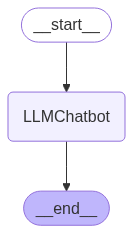

In [13]:
graph

In [16]:
response = graph.invoke({"messages":"Hi"})

In [17]:
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='23dd507c-fddf-48ac-8f29-354aff05e97e'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C5ImtxAWHsMBndjh6HFvVK9oHBpRV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--74ba38af-425d-43d0-8b6c-208dfb0d334c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [18]:
response['messages'][-1].content

'Hello! How can I assist you today?'